In [1]:
#https://www.kaggle.com/zhenyufan/nlp-for-yelp-reviews
#https://github.com/Bench-amblee/yelp_sentiment_analysis/blob/main/notebooks/yelpNLP3-processing.ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
yelp_df = pd.read_csv('yelp.csv')
yelp_df.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   business_id  10000 non-null  object
 1   date         10000 non-null  object
 2   review_id    10000 non-null  object
 3   stars        10000 non-null  int64 
 4   text         10000 non-null  object
 5   type         10000 non-null  object
 6   user_id      10000 non-null  object
 7   cool         10000 non-null  int64 
 8   useful       10000 non-null  int64 
 9   funny        10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [5]:
yelp_df = yelp_df.drop(['business_id', 'date', 'review_id', 'type', 'user_id'], axis=1)
yelp_df = yelp_df.rename(columns={'stars':'Stars', 'text':'Text', 'cool':'Cool', 'useful':'Useful', 'funny':'Funny'})
yelp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Stars   10000 non-null  int64 
 1   Text    10000 non-null  object
 2   Cool    10000 non-null  int64 
 3   Useful  10000 non-null  int64 
 4   Funny   10000 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 390.8+ KB


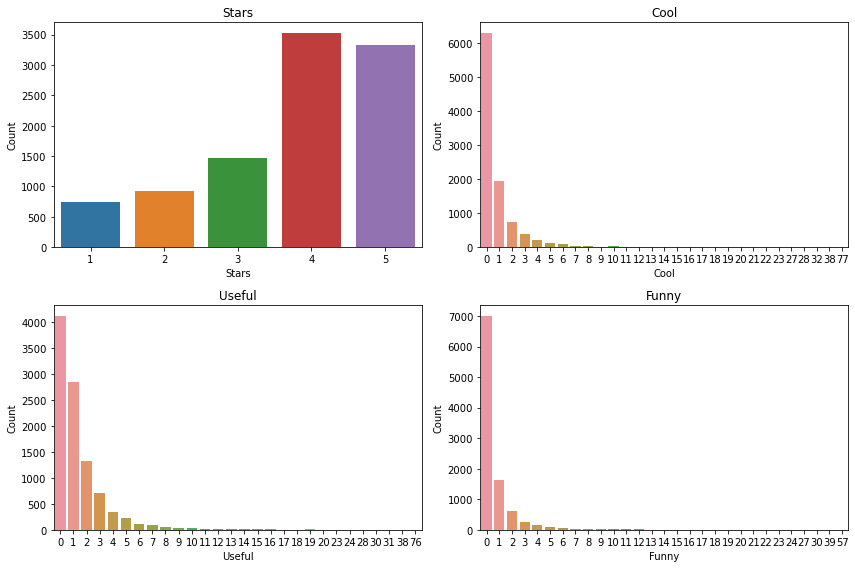

In [6]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(12,8))
axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='Stars', data=yelp_df)
axes1.set_title('Stars')
axes1.set_ylabel('Count')

axes2 = plt.subplot(2,2,2)
axes2 = sns.countplot(x='Cool', data=yelp_df)
axes2.set_title('Cool')
axes2.set_ylabel('Count')

axes3 = plt.subplot(2,2,3)
axes3 = sns.countplot(x='Useful', data=yelp_df)
axes3.set_title('Useful')
axes3.set_ylabel('Count')

axes4 = plt.subplot(2,2,4)
axes4 = sns.countplot(x='Funny', data=yelp_df)
axes4.set_title('Funny')
axes4.set_ylabel('Count')

plt.tight_layout()

In [7]:
yelp_df["Stars"] = np.where((yelp_df["Stars"] >= 3), "Happy","Sad")

In [8]:
yelp_df.head()

,Stars,Text,Cool,Useful,Funny
0,Happy,My wife took me here on my birthday for breakf...,2,5,0
1,Happy,I have no idea why some people give bad review...,0,0,0
2,Happy,love the gyro plate. Rice is so good and I als...,0,1,0
3,Happy,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0
4,Happy,General Manager Scott Petello is a good egg!!!...,0,0,0


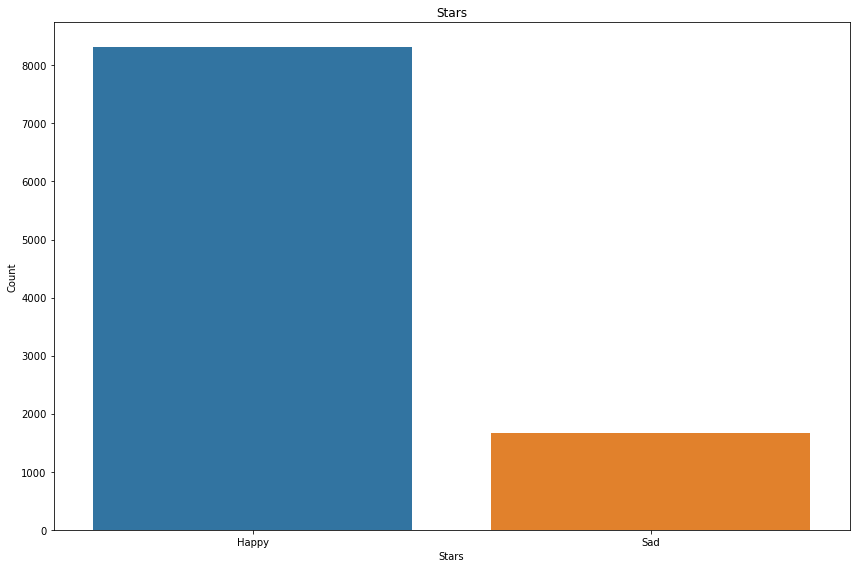

In [9]:
warnings.filterwarnings("ignore")

fig = plt.figure(figsize=(12,8))
#axes1 = plt.subplot(2,2,1)
axes1 = sns.countplot(x='Stars', data=yelp_df)
axes1.set_title('Stars')
axes1.set_ylabel('Count')
plt.tight_layout()

In [11]:
features = yelp_df.iloc[:,[1]].values
label = yelp_df.iloc[:,0].values

In [14]:
features

array([['My wife took me here on my birthday for breakfast and it was excellent.  The weather was perfect which made sitting outside overlooking their grounds an absolute pleasure.  Our waitress was excellent and our food arrived quickly on the semi-busy Saturday morning.  It looked like the place fills up pretty quickly so the earlier you get here the better.\n\nDo yourself a favor and get their Bloody Mary.  It was phenomenal and simply the best I\'ve ever had.  I\'m pretty sure they only use ingredients from their garden and blend them fresh when you order it.  It was amazing.\n\nWhile EVERYTHING on the menu looks excellent, I had the white truffle scrambled eggs vegetable skillet and it was tasty and delicious.  It came with 2 pieces of their griddled bread with was amazing and it absolutely made the meal complete.  It was the best "toast" I\'ve ever had.\n\nAnyway, I can\'t wait to go back!'],
       ['I have no idea why some people give bad reviews about this place. It goes to sh